In [114]:
import warnings

warnings.filterwarnings("ignore")

import os.path
import ssm
import pickle
import numpy as np
import pandas as pd
import scipy
import copy
from tqdm import tqdm

from runwise_ts_log_data import get_ts_log_data_blocked

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import to_rgba
import seaborn as sns

from sympy.utilities.iterables import multiset_permutations
from ssm.util import *
from scipy.stats import ttest_ind, wilcoxon, ranksums

In [115]:
with open('pkl/emoprox2_dataset_timeseries+inputs5_MAX85.pkl','rb') as f:
    orig_df = pickle.load(f)
subj_list = sorted(orig_df['pid'].unique())
# subj_list = subj_list[:] # remove first 30 subjects
orig_df = orig_df[orig_df['pid'].isin(subj_list)]

In [116]:
K = 6
D = 10
N = 85
num_subjs = 92
M=10
idx_sample = 2

In [117]:

with open(f'pkl/rslds_emoprox2_K{K}_D{D}_N{85}_M{10}_{num_subjs}subjs_origsample{idx_sample}.pkl','rb') as f:
    model, q, elbos, resampled_subj_list = pickle.load(f)

resampled_df = []
for pid in resampled_subj_list:
    resampled_df.append(orig_df[orig_df["pid"] == pid])
resampled_df = pd.concat(resampled_df).reset_index().drop("index", axis=1)
df = resampled_df

df["continuous_states"] = [None] * df.shape[0]
df["discrete_states"] = [None] * df.shape[0]
hrflag = 0
prox_bins = list(np.arange(M // 2) / (M // 2))[1:]
dir_bins = [0]
nprox = len(prox_bins) + 1
ndir = len(dir_bins) + 1
for idx_row in range(df.shape[0]):
    prox = df.loc[idx_row]["proximity"]
    prox = prox - prox.min()
    prox = prox / prox.max()
    proxd = np.digitize(prox, bins=prox_bins)
    dird = 1 - np.digitize(df.loc[idx_row]["direction"], bins=dir_bins)
    stim_category = (nprox * ndir - 1) * dird + ((-1) ** dird) * proxd
    input = np.roll(np.eye(nprox * ndir)[stim_category], shift=hrflag, axis=0)

    y = df.loc[idx_row]["timeseries"]
    x = q.mean_continuous_states[idx_row]
    z = model.most_likely_states(x, y, input=input)
    df.at[idx_row, "continuous_states"] = x
    df.at[idx_row, "discrete_states"] = z
    prox = df.loc[idx_row]["proximity"]
    prox = prox - prox.min()
    prox = prox / prox.max()
    df.at[idx_row, "proximity"] = prox

[0.6775356070238617, 0.7359426585220169, 0.7943871564622721, 0.833672320389194, 0.861226685645869, 0.9910251891466971]


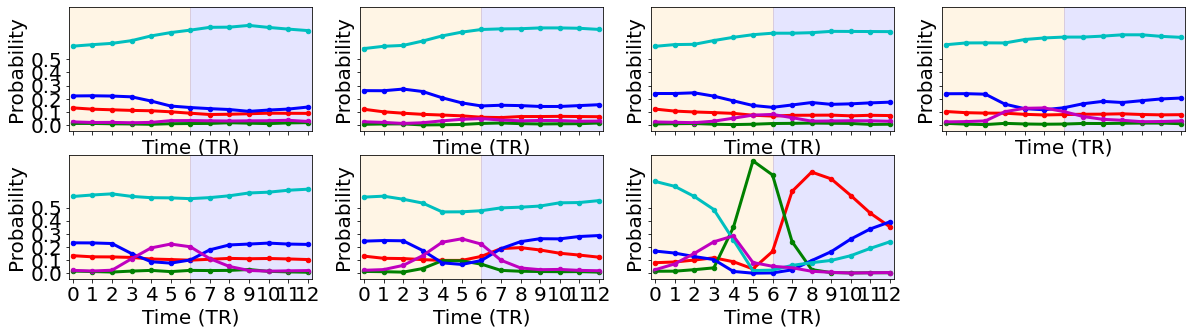

In [118]:
from scipy.signal import argrelextrema

def find_windows_and_local_maxima(values, censor, window_length, hrf_lag=3):
    local_maxima_indices = argrelextrema(values, np.greater)[0]
    windows = []
    local_maxima = []
    for idx in local_maxima_indices:
        if idx - window_length // 2 + hrf_lag >= 0 and idx + window_length // 2 + hrf_lag < len(values) :
            window_start = idx - window_length // 2 + hrf_lag
            window_end = idx + window_length // 2 + hrf_lag
            windows.append((window_start, window_end))
            local_maxima.append(values[idx])
    return windows, local_maxima

def get_x_prox(df):
    local_maxima_all = []
    windows_all = []
    states_all_windows = []
    for idx_row in range(df.shape[0]):
        prox = df.loc[idx_row]['proximity']
        censor = df.loc[idx_row]['censor'][:,0]
        xs = df.loc[idx_row]['continuous_states']
        states = df.loc[idx_row]['discrete_states']
        window_length = 12
        windows, local_maxima = find_windows_and_local_maxima(prox, censor, window_length)
        local_maxima_all += local_maxima
        windows_all += windows
        states_all_windows += [states[l:r+1] for l,r in windows]
    states_all_windows = np.vstack(states_all_windows)
    local_maxima_all = np.array(local_maxima_all)
    return states_all_windows, local_maxima_all

states_all_windows, local_maxima_all = get_x_prox(df)
colors = 'rgbcmyk'
state_names = [f'State{i+1}' for i in range(K)]
ncols=4
local_maxima_bins = [np.quantile(local_maxima_all,i) for i in np.arange(0,1,1/7)[1:]]
print(local_maxima_bins)
bin_indices = np.digitize(local_maxima_all,bins=local_maxima_bins)
fig,axs = plt.subplots(nrows=2, ncols=4, figsize=(20,5), sharex=True, sharey=True)
for i_bin in range(len(local_maxima_bins)+1):
    ax = axs[i_bin//ncols][i_bin%ncols]
    # find states coresponding to all windows belonging to that bin
    z_bin = states_all_windows[bin_indices==i_bin,:]
    state_window_probs = np.stack(
        [np.array([(z_bin[:,tr]==k).sum() for k in range(model.K)])
          for tr in range(z_bin.shape[1])]
          ,axis=1)
    state_window_probs = state_window_probs / state_window_probs.sum(axis=0)
    
    ax.axvspan(-1,6,alpha=0.1, color='orange')
    ax.axvspan(6,13,alpha=0.1, color='blue')
    for k in [0,1,2,3,4]:
        ax.plot(state_window_probs[k,:],color=colors[k],label=state_names[k],linewidth=3)
        ax.scatter(np.arange(z_bin.shape[1]),state_window_probs[k,:],color=colors[k],s=20)
    ax.set_xticks(np.arange(z_bin.shape[1]))
    ax.set_xticklabels(np.arange(z_bin.shape[1]),fontsize=20,rotation=0)
    ax.set_yticks(0.1*np.arange(6))
    ax.set_xlim([0-0.2,z_bin.shape[1]-1+0.2])
    # ax.set_ylim([0,0.5])
    ax.set_ylabel('Probability',fontsize=20)
    ax.set_xlabel('Time (TR)',fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=20)
    min_prox = min(local_maxima_all[bin_indices==i_bin])
    max_prox = max(local_maxima_all[bin_indices==i_bin])
    # ax.set_title(f'max proximity $\in$ ({min_prox:.02f},{max_prox:.02f}) ',fontsize=12)
patchs = []
for state_name,color in zip(state_names,colors):
    if state_name in ["approach"]:
        patchs.append(mpatches.Patch(color=color, label=state_name))
fig.delaxes(axs[1][ncols-1])
axs[1][ncols-1].legend(handles=patchs,fontsize=20,ncol=1,loc='right')#,bbox_to_anchor=(1.6, 0.5))
fig.savefig(f'figures/fig_approach_retreat_state_count_K{model.K}.jpeg',dpi=600,bbox_inches='tight')

In [119]:
winlen = 10

def get_begin_responses(y,z,st_i,win=winlen):
    ret = []
    ret_z = []
    for t in range(len(z)-win):
        if z[t]==st_i: 
            if t==0:
                # if np.all(z[t:t+win]==st_i):
                    ret.append(y[t:t+win])
                    ret_z.append(z[t:t+win])
            elif z[t-1]!=st_i:
                # if np.all(z[t:t+win]==st_i):
                    ret.append(y[t:t+win])
                    ret_z.append(z[t:t+win])
    # if len(ret)>0: return np.mean(np.stack(ret,axis=0),axis=0)
    # else: return None
    return ret,ret_z



def bootstrap_err(sample):
    means = np.zeros(100)
    for i in range(100):
        means[i] = np.random.choice(sample,len(sample),replace=True).mean()
    return means.std()*1.96

def bootstrap_err_matrix(X):
    ret = np.zeros_like(X[0])
    for i in range(X[0].shape[0]):
        for j in range(X[0].shape[1]):
            ret[i,j] = bootstrap_err(X[:,i,j])
    return ret

from scipy.stats import mode

def get_mean_state_response(df,state_from):
    subj_list = df.pid.unique()
    begin_responses = []
    begin_states = []
    for pid in subj_list:
        df_subj = df[df.pid==pid]
        z_subj = np.hstack(list(df_subj.discrete_states.values))
        y_subj = np.vstack(list(df_subj['continuous_states'].values))
        y_begin,z_begin = get_begin_responses(y_subj,z_subj,state_from)
        begin_responses += y_begin
        begin_states += z_begin
    begin_responses = np.stack(begin_responses,axis=0)
    begin_states = np.stack(begin_states,axis=0)
    mean_begin_response = begin_responses.mean(axis=0)
    mode_begin_state = mode(begin_states)
    
    return mean_begin_response, mode_begin_state#mean_end_response

ModeResult(mode=array([[0, 0, 0, 0, 0, 0, 0, 0, 3, 3]]), count=array([[3416, 3150, 2736, 2300, 1910, 1576, 1322, 1136, 1241, 1400]]))
ModeResult(mode=array([[1, 1, 0, 0, 0, 0, 0, 0, 2, 3]]), count=array([[3039, 2383, 1414, 2075, 2079, 1846, 1505, 1223, 1002, 1034]]))
ModeResult(mode=array([[2, 2, 2, 2, 2, 2, 2, 3, 3, 3]]), count=array([[3872, 3827, 3590, 3224, 2734, 2257, 1795, 1807, 1969, 2060]]))
ModeResult(mode=array([[3, 3, 3, 3, 3, 3, 3, 3, 3, 3]]), count=array([[5216, 5073, 4900, 4690, 4461, 4261, 4080, 3896, 3755, 3648]]))
ModeResult(mode=array([[4, 4, 4, 2, 2, 2, 2, 2, 2, 3]]), count=array([[3377, 2819, 1817,  917, 1209, 1311, 1324, 1316, 1301, 1277]]))


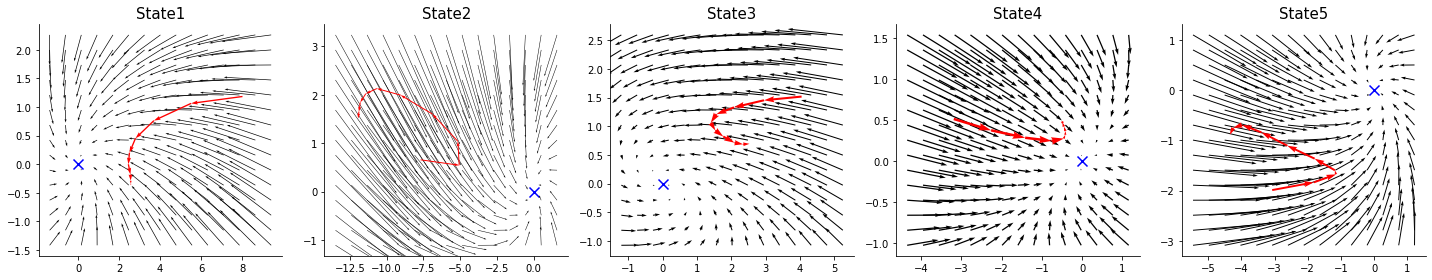

In [120]:

def get_flow1(normals,A,b,ax):
    xmin,xmax = ax.get_xlim()
    ymin,ymax = ax.get_ylim()
    xtup = (xmin-1,xmax+1,15)
    ytup = (ymin-1,ymax+1,15)

    apply_dynamics = lambda x: A @ x + b

    x_bar = (np.linalg.inv(np.eye(D)-A) @ b) 
    x_bar2d = (np.linalg.inv(np.eye(D)-A) @ b) @ normals

    two_to_lat = lambda x: (x) @ normals.T + x_bar
    lat_to_two = lambda x: x @ normals - x_bar2d
       
    x_range = np.linspace(*xtup)
    y_range = np.linspace(*ytup)
    x_coords, y_coords = np.meshgrid(x_range,y_range)
    for point in zip(x_coords.flatten(), y_coords.flatten()):
        v = np.array(point) # 2D
        v_latent = two_to_lat(v) # latent space 
        
        v_next = lat_to_two(apply_dynamics(v_latent)) # 2D
        dv = v_next - v

        dv1 = lat_to_two(apply_dynamics(v_latent)-v_latent) # 2D

        ax.quiver(v[0],v[1],dv[0],dv[1],units='xy',angles='xy',scale_units='xy',scale=1,width=0.025,color='k')
        # ax.quiver(v[0],v[1],dv1[0],dv1[1],units='xy',scale=1,width=0.05,color='r')

def get_traj1(normals,x,A,b,ax,col):

    x_bar2d = (np.linalg.inv(np.eye(D)-A) @ b) @ normals
    lat_to_two = lambda x: x @ normals - x_bar2d

    x2d = np.zeros((x.shape[0],2))
    for t in range(x.shape[0]):
        x2d[t,:] = lat_to_two(x[t,:])
    for t in range(x.shape[0]-1):
        v = x2d[t,:]
        dv = x2d[t+1,:] - v
        ax.quiver(v[0],v[1],dv[0],dv[1],units='xy',angles='xy',scale_units='xy',scale=1,width=0.05,color=col)

def get_fixed_point1(ax):
    ax.scatter(0,0,color='b',marker='x',s=100)

As = model.dynamics.As
bs = model.dynamics.bs

xs = np.vstack(list(df['continuous_states'].values))

cov = np.corrcoef(xs.T)
U,Lam,V = np.linalg.svd(cov)
pcs = U[:,:2] # using top 2 principal components
fig,axs = plt.subplots(nrows=1,ncols=K-1,figsize=(20,4),sharex=False,sharey=False)
for k in range(K-1):
    begin_resp, begin_state = get_mean_state_response(df,k)
    print(begin_state)
    # all_resp = np.vstack([begin_resp,end_resp])
    sigma = begin_resp.T @ begin_resp
    U,Lam,V = np.linalg.svd(sigma)
    normals = U[:,:2]
    ax = axs[k]
    get_fixed_point1(ax)
    get_traj1(normals,begin_resp,As[k],bs[k],ax,'white')
    get_flow1(normals,As[k],bs[k],ax)
    get_traj1(normals,begin_resp,As[k],bs[k],ax,'red')
    # get_traj1(normals,end_resp,As[k],bs[k],ax,'green')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_title(f'State{k+1}',fontsize=15)
fig.tight_layout()